In [ ]:
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Collection

## Set Up

In [ ]:
import os
os.environ['TOKEN'] = "AAAAAAAAAAAAAAAAAAAAAIi0jQEAAAAAk2nnTNI41oHHdehJLOXXv36J6%2F0%3DnnMdA329Tb9YGoAo6vgGLjvEVG0m8WwCs3ZHQNqGHLC2fUdz3v"
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = "/content/"
error_log_path = "/content/"

In [ ]:
import requests 
import pandas as pd 
import time

## Auth

In [ ]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers
headers = create_headers(os.environ['TOKEN'])

## Search Query

In [ ]:
def create_url(query, start_time, end_time, max_results, expansions, tweet_fields, user_fields, place_fields, endpoint):
    
    search_url = endpoint #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    #also can request different fields, e.g ids of users ... 
    query_params = {'query': query,
                    'end_time': end_time,
                    'start_time': start_time,
                    'max_results': max_results,
                    'expansions': expansions,
                    'tweet.fields': tweet_fields,
                    'user.fields': user_fields,
                    'place.fields': place_fields}

    return (search_url, query_params)

In [ ]:
def connect_to_endpoint(url, headers, params, next_token = None):
    #only change the default value of next_token if it is a real value returned in the response
    if next_token is not None and next_token != '':
      params['next_token'] = next_token
    #create a "GET" request to the specified url, add headers and parameters
    response = requests.request("GET", url, headers = headers, params = params)
    if response.status_code != 200:
        #if something goes wrong, we need to know
        raise Exception(response.status_code, response.text)
    #otherwise, we want the payload of our response, which contains our tweet(s)
    return response.json()

In [ ]:
def get_data(query, start_time, end_time, max_results, expansions, tweet_fields, user_fields, place_fields, endpoint, next_token=""):
  
  results = []


  while next_token is not None:
    try:    
      url = create_url(query, start_time, end_time, max_results, expansions, tweet_fields, user_fields, place_fields, endpoint)
      json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
      #if we have results, they will be in the field 'data' of our response
      if "data" in json_response:
        results.extend(json_response["data"])
        print(str(len(json_response["data"])) + " Tweets downloaded in this batch.")
      #the next_token is added to the field 'meta' of our response
      if "meta" in json_response:
        if "next_token" in json_response["meta"].keys():
          next_token = json_response["meta"]["next_token"]          
        else:
          next_token = None
      else:
        next_token = None

      
      #to control the rate limit we need to slow down our download
      time.sleep(3)

    except Exception as e:
      print("Error occured", e)
      print("Next token value", next_token)
      error_log = {"Error":e, "Next token":next_token, "Day":start_time, 
                   "Downloaded":len(results)}
      pd.DataFrame.from_dict(error_log, orient="index").to_csv(error_log_path+query+"_"+start_time+"_"+next_token+".csv")
      return(results, next_token)

  print("Done")
  
  return (results, next_token)

## Download And Save

In [ ]:
start_time = "2022-11-25T13:00:00.000Z"
end_time = "2022-11-25T13:00:20.000Z"
query_text = "#Qatar2022"
endpoint = "https://api.twitter.com/2/tweets/search/recent/"
path = "/content/"
max_results = 100
no_days = 15

In [ ]:
tweets = get_data(query_text, start_time = start_time, end_time = end_time, 
          max_results=max_results, expansions='author_id,in_reply_to_user_id,geo.place_id', 
          tweet_fields='id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source,entities',
          user_fields='id,name,username,created_at,description,public_metrics,verified',
          place_fields='full_name,id,country,country_code,geo,name,place_type',
          endpoint=endpoint)[0]          
tweets_df = pd.DataFrame(tweets)
tweets_df.to_pickle(path+"_tweets.pkl")

# Working with Data

## Upload

In [ ]:
import pandas as pd
path = "/content/"
error_log_path = "/content/"

In [ ]:
tweets_df = pd.read_pickle(path+"tweets.pkl")

In [ ]:
tweets_df

,entities,lang,author_id,text,created_at,public_metrics,reply_settings,id,conversation_id,edit_history_tweet_ids,referenced_tweets,geo,withheld
0,"{'urls': [{'start': 152, 'end': 175, 'url': 'h...",en,819019776844513280,"#Trump SUCKERS, RIPS OFF #MAGA #GOP #Republica...",2022-12-15T12:58:24.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,1603373910254407681,1603373910254407681,[1603373910254407681],NaN,NaN,NaN
1,"{'urls': [{'start': 75, 'end': 98, 'url': 'htt...",en,1342278448040042497,How to stop wealthy right-wing 'Christians' fr...,2022-12-15T12:58:10.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,1603373854432395264,1603373854432395264,[1603373854432395264],NaN,NaN,NaN
2,"{'urls': [{'start': 28, 'end': 51, 'url': 'htt...",und,173591614,#Republicans are #Fascists. https://t.co/ntFoJ...,2022-12-15T12:58:08.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,1603373844701421568,1603373844701421568,[1603373844701421568],"[{'type': 'quoted', 'id': '1602834879783256064'}]",NaN,NaN
3,"{'urls': [{'start': 226, 'end': 249, 'url': 'h...",en,173591614,#Fascists #Republicans who tried and are conti...,2022-12-15T12:56:56.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,1603373543256899584,1603373543256899584,[1603373543256899584],"[{'type': 'quoted', 'id': '1602469623814934528'}]",NaN,NaN
4,"{'urls': [{'start': 0, 'end': 23, 'url': 'http...",en,455792914,https://t.co/AYYixDBhMu\nHe has LOST HIS MIND ...,2022-12-15T12:56:55.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,1603373539624722434,1603373539624722434,[1603373539624722434],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24976,"{'urls': [{'start': 90, 'end': 113, 'url': 'ht...",qme,1250960911088615424,#Iowa #Democrats #Vote #USAToday #FoxNews @USA...,2022-12-01T13:01:14.000Z,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",everyone,1598301194576855040,1598301194576855040,[1598301194576855040],NaN,NaN,NaN
24977,"{'urls': [{'start': 99, 'end': 122, 'url': 'ht...",en,1197153670183428096,Dallas store customer fatally shoots suspected...,2022-12-01T13:00:37.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,1598301040570667014,1598301040570667014,[1598301040570667014],NaN,NaN,NaN
24978,"{'hashtags': [{'start': 3, 'end': 15, 'tag': '...",en,598925796,Yo #Republicans! Yes...I'm speaking to you. ...,2022-12-01T13:00:30.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,1598301010803712000,1598301010803712000,[1598301010803712000],NaN,NaN,NaN
24979,"{'urls': [{'start': 274, 'end': 297, 'url': 'h...",en,710480344953327617,These ppl are the back bone of country just li...,2022-12-01T13:00:13.000Z,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",everyone,1598300940955688962,1598300940955688962,[1598300940955688962],NaN,NaN,NaN


## Preprocessing

In [ ]:
tweets_filtered = tweets_df.copy() #it's a good idea to work on the copy of original dataframe, so we can always go back to it if we mess something up
column_list = ["id","author_id","created_at", "text","entities","public_metrics", "lang"]
tweets_filtered = tweets_filtered[column_list]

In [ ]:
tweets_filtered

,id,author_id,created_at,text,entities,public_metrics,lang
0,1603373910254407681,819019776844513280,2022-12-15T12:58:24.000Z,"#Trump SUCKERS, RIPS OFF #MAGA #GOP #Republica...","{'urls': [{'start': 152, 'end': 175, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en
1,1603373854432395264,1342278448040042497,2022-12-15T12:58:10.000Z,How to stop wealthy right-wing 'Christians' fr...,"{'urls': [{'start': 75, 'end': 98, 'url': 'htt...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en
2,1603373844701421568,173591614,2022-12-15T12:58:08.000Z,#Republicans are #Fascists. https://t.co/ntFoJ...,"{'urls': [{'start': 28, 'end': 51, 'url': 'htt...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",und
3,1603373543256899584,173591614,2022-12-15T12:56:56.000Z,#Fascists #Republicans who tried and are conti...,"{'urls': [{'start': 226, 'end': 249, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en
4,1603373539624722434,455792914,2022-12-15T12:56:55.000Z,https://t.co/AYYixDBhMu\nHe has LOST HIS MIND ...,"{'urls': [{'start': 0, 'end': 23, 'url': 'http...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en
...,...,...,...,...,...,...,...
24976,1598301194576855040,1250960911088615424,2022-12-01T13:01:14.000Z,#Iowa #Democrats #Vote #USAToday #FoxNews @USA...,"{'urls': [{'start': 90, 'end': 113, 'url': 'ht...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",qme
24977,1598301040570667014,1197153670183428096,2022-12-01T13:00:37.000Z,Dallas store customer fatally shoots suspected...,"{'urls': [{'start': 99, 'end': 122, 'url': 'ht...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en
24978,1598301010803712000,598925796,2022-12-01T13:00:30.000Z,Yo #Republicans! Yes...I'm speaking to you. ...,"{'hashtags': [{'start': 3, 'end': 15, 'tag': '...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en
24979,1598300940955688962,710480344953327617,2022-12-01T13:00:13.000Z,These ppl are the back bone of country just li...,"{'urls': [{'start': 274, 'end': 297, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en


## Sentiment Analysis Addition

In [ ]:
import nltk
import re
import string
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def cleaner_sentiment(tweet):
    tweet = re.sub("@\w+","",tweet) # remove mentions
    tweet = re.sub("#\w+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    return tweet

In [ ]:
tweets_filtered['sentiment'] = tweets_filtered['text'].apply(lambda testo: sid.polarity_scores(cleaner_sentiment(testo))['compound'])

## Extract Words/Hashtags

In [ ]:
# NLTK tools
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("english")
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
tokenizer = nltk.RegexpTokenizer(r'\w+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
stop_words.append('amp')

In [ ]:
def cleaner(tweet):
    tweet = re.sub("@\w+","",tweet) # remove mentions
    tweet = re.sub("#\w+", "",tweet) # remove hashtags
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = " ".join(w for w in tokenizer.tokenize(tweet) if ((not w.lower() in stop_words) and len(w)>1 ))
    #remove stop words
    lemma_function = WordNetLemmatizer()
    tweet = " ".join(lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in nltk.pos_tag(nltk.wordpunct_tokenize(tweet))) #lemmatize
    tweet = str.lower(tweet) #to lowercase
    return tweet

In [ ]:
tweets_filtered["clean_text"] = tweets_filtered["text"].map(cleaner)

In [ ]:
tweets_filtered

,id,author_id,created_at,text,entities,public_metrics,lang,sentiment,clean_text
0,1603373910254407681,819019776844513280,2022-12-15T12:58:24.000Z,"#Trump SUCKERS, RIPS OFF #MAGA #GOP #Republica...","{'urls': [{'start': 152, 'end': 175, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,-0.5106,suckers rips mine mine mine mine
1,1603373854432395264,1342278448040042497,2022-12-15T12:58:10.000Z,How to stop wealthy right-wing 'Christians' fr...,"{'urls': [{'start': 75, 'end': 98, 'url': 'htt...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,0.5994,stop wealthy right wing christians bribe supre...
2,1603373844701421568,173591614,2022-12-15T12:58:08.000Z,#Republicans are #Fascists. https://t.co/ntFoJ...,"{'urls': [{'start': 28, 'end': 51, 'url': 'htt...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",und,0.0000,
3,1603373543256899584,173591614,2022-12-15T12:56:56.000Z,#Fascists #Republicans who tried and are conti...,"{'urls': [{'start': 226, 'end': 249, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,0.0000,try continue try overthrow us govt democracy i...
4,1603373539624722434,455792914,2022-12-15T12:56:55.000Z,https://t.co/AYYixDBhMu\nHe has LOST HIS MIND ...,"{'urls': [{'start': 0, 'end': 23, 'url': 'http...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,-0.5622,lost mind medium fall
...,...,...,...,...,...,...,...,...,...
24976,1598301194576855040,1250960911088615424,2022-12-01T13:01:14.000Z,#Iowa #Democrats #Vote #USAToday #FoxNews @USA...,"{'urls': [{'start': 90, 'end': 113, 'url': 'ht...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",qme,0.0000,
24977,1598301040570667014,1197153670183428096,2022-12-01T13:00:37.000Z,Dallas store customer fatally shoots suspected...,"{'urls': [{'start': 99, 'end': 122, 'url': 'ht...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,-0.8225,dallas store customer fatally shoots suspect b...
24978,1598301010803712000,598925796,2022-12-01T13:00:30.000Z,Yo #Republicans! Yes...I'm speaking to you. ...,"{'hashtags': [{'start': 3, 'end': 15, 'tag': '...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,0.7602,yo yes speak heck plan save offer comfort
24979,1598300940955688962,710480344953327617,2022-12-01T13:00:13.000Z,These ppl are the back bone of country just li...,"{'urls': [{'start': 274, 'end': 297, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,0.6597,ppl back bone country like trucker fight well ...


In [ ]:
tweets_filtered.loc[tweets_filtered["clean_text"].isnull(),"clean_text"] = ""

In [ ]:
#initialize an empty dict
unique_words = {}
unique_weights = {}

for idx, row in tweets_filtered.iterrows():
  if row["clean_text"] != "":
    for word in tokenizer.tokenize(row["clean_text"]):
      unique_words.setdefault(word,0)
      unique_words[word] += 1
      unique_weights.setdefault(word,float(0))
      unique_weights[word] += float(row["sentiment"])

In [ ]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df['Sentiment'] = uw_df['Word'].apply(lambda word: unique_weights[word])/uw_df['Count']
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df = uw_df.reset_index().drop(columns=["index"])
uw_df['Sentiment'] = ((uw_df['Sentiment'])**(1/2)).fillna(0)-((-uw_df['Sentiment'])**(1/2)).fillna(0)

In [ ]:
uw_df

,Word,Count,Sentiment
0,party,1673,0.485399
1,get,1559,-0.243033
2,vote,1534,-0.226414
3,people,1443,-0.308845
4,say,1381,-0.317729
...,...,...,...
19725,specialize,1,-0.357771
19726,qari,1,-0.600999
19727,prefect,1,0.779230
19728,641,1,0.589067


### Extract Hashtags

In [ ]:
tweets_filtered.loc[tweets_df["entities"].isnull(), "entities"] = None
tweets_filtered["hashtags"] = ""

In [ ]:
unique_hashtags = {}
unique_hweights = {}
index = 0

for idx, row in tweets_filtered.iterrows():
  if row["entities"] is not None and "hashtags" in row["entities"]:
    hl = []
    for hashtag in row["entities"]["hashtags"]:
      tag = '#' + hashtag["tag"].lower()
      unique_hashtags.setdefault(tag, 0)
      unique_hashtags[tag] += 1
      hl.append(tag)
      unique_hweights.setdefault(tag,float(0))
      unique_hweights[tag] += float(row["sentiment"])
 
    tweets_filtered.at[idx,"hashtags"] = hl

In [ ]:
unique_hashtags = dict(sorted(unique_hashtags.items(), key=lambda item: item[1], reverse=True))

In [ ]:
uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
uh_df['Sentiment'] = uh_df['Hashtag'].apply(lambda tag: unique_hweights[tag])/uh_df['Count']
uh_df['Sentiment'] = ((uh_df['Sentiment'])**(1/2)).fillna(0)-((-uh_df['Sentiment'])**(1/2)).fillna(0)

In [ ]:
uh_df

,Hashtag,Count,Sentiment
0,#democrats,11842,-0.212925
1,#republicans,8210,-0.219785
2,#republican,5623,-0.150426
3,#democrat,3107,-0.158615
4,#trump,3068,-0.223627
...,...,...,...
14982,#corporatewelfare,1,-0.900278
14983,#margin,1,0.000000
14984,#total,1,0.000000
14985,#contests,1,0.000000


## Build Network

In [ ]:
import itertools
import networkx as nx

In [ ]:
uh = unique_hashtags.keys()
uw = unique_words.keys()

In [ ]:
network = {}
hnetwork = {}
wnetwork = {}
network_key = 0
for index, row in tweets_filtered.iterrows():
    combined_list = [hashtag for hashtag in row["hashtags"]] + [word for word in str.split(row["clean_text"], " ") if word in uw]
    #itertool product creates Cartesian product of each element in the combined list
    for pair in itertools.product(combined_list, combined_list):
        #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
        if pair[0]!=pair[1] and not(pair[::-1] in network):
            network.setdefault(pair,0)
            network[pair] += 1
    hashtag_list = [hashtag for hashtag in row["hashtags"]]
    for pair in itertools.product(hashtag_list, hashtag_list):
        if pair[0]!=pair[1] and not(pair[::-1] in hnetwork):
            hnetwork.setdefault(pair,0)
            hnetwork[pair] += 1
    word_list = [word for word in str.split(row["clean_text"], " ") if word in uw]
    for pair in itertools.product(word_list, word_list):
        if pair[0]!=pair[1] and not(pair[::-1] in wnetwork):
            wnetwork.setdefault(pair,0)
            wnetwork[pair] += 1

network_df = pd.DataFrame.from_dict(network, orient="index")
hnetwork_df = pd.DataFrame.from_dict(hnetwork, orient="index")
wnetwork_df = pd.DataFrame.from_dict(wnetwork, orient="index")

In [ ]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df

,pair,weight
39,"(#republicans, #democrats)",1988
25,"(#gop, #republicans)",1565
5840,"(#trump, #republican)",1467
1315,"(#republican, #conservative)",1287
2,"(#trump, #republicans)",1285
...,...,...
195754,"(99, lt)",1
195756,"(#nancypelosi, #trump2024)",1
795356,"(proposals, spending)",1
795354,"(#leftist, online)",1


In [ ]:
hnetwork_df.reset_index(inplace=True)
hnetwork_df.columns = ["pair","weight"]
hnetwork_df.sort_values(by="weight",inplace=True, ascending=False)
hnetwork_df

,pair,weight
30,"(#republicans, #democrats)",1988
19,"(#gop, #republicans)",1565
1235,"(#trump, #republican)",1467
212,"(#republican, #conservative)",1287
2,"(#trump, #republicans)",1285
...,...,...
86809,"(#partisanship, #goodpods)",1
86810,"(#opinionpiece, #democrats)",1
86811,"(#opinionpiece, #republicans)",1
86812,"(#opinionpiece, #government)",1


In [ ]:
wnetwork_df.reset_index(inplace=True)
wnetwork_df.columns = ["pair","weight"]
wnetwork_df.sort_values(by="weight",inplace=True, ascending=False)
wnetwork_df

,pair,weight
8378,"(joe, biden)",314
6798,"(elon, musk)",246
10833,"(get, vote)",211
7861,"(hunter, biden)",201
44722,"(donald, trump)",188
...,...,...
383793,"(nah, bad)",1
383794,"(nah, insult)",1
383795,"(bad, insult)",1
383797,"(shoplifting, utter)",1


In [ ]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

hup_weighted = []
for edge in hnetwork:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    hup_weighted.append((edge[0],edge[1],hnetwork[edge]))

wup_weighted = []
for edge in wnetwork:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    wup_weighted.append((edge[0],edge[1],wnetwork[edge]))


G = nx.Graph()
hG = nx.Graph()
wG = nx.Graph()
G.add_weighted_edges_from(up_weighted)
hG.add_weighted_edges_from(hup_weighted)
wG.add_weighted_edges_from(wup_weighted)

In [ ]:
print(len(G.nodes()))
print(len(G.edges()))
print(len(hG.nodes()))
print(len(hG.edges()))
print(len(wG.nodes()))
print(len(wG.edges()))

34717
1637666
14987
204007
19712
907048


In [ ]:
nx.write_gpickle(G,path+"network.pkl")
nx.write_gpickle(hG,path+"hnetwork.pkl")
nx.write_gpickle(wG,path+"wnetwork.pkl")

In [ ]:
filename = path+"/edgelist.csv"
nx.write_weighted_edgelist(G, filename, delimiter=",")
#add header with appropriate column names (works on collab and Linux/Mac(?))
!sed -i.bak 1i"Source,Target,Weight" ./edgelist.csv

In [ ]:
filename = path+"/hedgelist.csv"
nx.write_weighted_edgelist(hG, filename, delimiter=",")
#add header with appropriate column names (works on collab and Linux/Mac(?))
!sed -i.bak 1i"Source,Target,Weight" ./hedgelist.csv

In [ ]:
filename = path+"/wedgelist.csv"
nx.write_weighted_edgelist(wG, filename, delimiter=",")
#add header with appropriate column names (works on collab and Linux/Mac(?))
!sed -i.bak 1i"Source,Target,Weight" ./wedgelist.csv

## Political Affiliation Addition

In [ ]:
uw_df['Political'] = float(0)
uh_df['Political'] = float(0)
uh_df['Political'][uh_df['Hashtag']=='#democrats'] = -1
uh_df['Political'][uh_df['Hashtag']=='#democrat'] = -1
uh_df['Political'][uh_df['Hashtag']=='#republicans'] = 1
uh_df['Political'][uh_df['Hashtag']=='#republican'] = 1

<ipython-input-648-1b6532e1daa3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uh_df['Political'][uh_df['Hashtag']=='#democrats'] = -1
<ipython-input-648-1b6532e1daa3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uh_df['Political'][uh_df['Hashtag']=='#democrat'] = -1
<ipython-input-648-1b6532e1daa3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uh_df['Political'][uh_df['Hashtag']=='#republicans'] = 1
<ipython-input-648-1b6532

In [ ]:
word_nodes = uw_df.copy()
word_nodes["Label"] = word_nodes["Word"]
word_nodes.rename(columns={"Word":"Id"},inplace=True)
word_nodes = word_nodes[['Id','Label','Count','Sentiment','Political']]

word_nodes

,Id,Label,Count,Sentiment,Political
0,party,party,1673,0.485399,0.0
1,get,get,1559,-0.243033,0.0
2,vote,vote,1534,-0.226414,0.0
3,people,people,1443,-0.308845,0.0
4,say,say,1381,-0.317729,0.0
...,...,...,...,...,...
19725,specialize,specialize,1,-0.357771,0.0
19726,qari,qari,1,-0.600999,0.0
19727,prefect,prefect,1,0.779230,0.0
19728,641,641,1,0.589067,0.0


In [ ]:
hashtag_nodes = uh_df.copy()
hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
hashtag_nodes.rename(columns={"Hashtag":"Id"},inplace=True)
hashtag_nodes = hashtag_nodes[['Id','Label','Count','Sentiment','Political']]

hashtag_nodes

,Id,Label,Count,Sentiment,Political
0,#democrats,#democrats,11842,-0.212925,-1.0
1,#republicans,#republicans,8210,-0.219785,1.0
2,#republican,#republican,5623,-0.150426,1.0
3,#democrat,#democrat,3107,-0.158615,-1.0
4,#trump,#trump,3068,-0.223627,0.0
...,...,...,...,...,...
14982,#corporatewelfare,#corporatewelfare,1,-0.900278,0.0
14983,#margin,#margin,1,0.000000,0.0
14984,#total,#total,1,0.000000,0.0
14985,#contests,#contests,1,0.000000,0.0


In [ ]:
hindex_order = []
for node in list(hG.nodes()):
  hindex_order.append(hashtag_nodes.index[hashtag_nodes['Id'] == node].tolist()[0])

In [ ]:
hashtag_nodes = hashtag_nodes.reindex(hindex_order)

In [ ]:
hashtag_nodes

,Id,Label,Count,Sentiment,Political
4,#trump,#trump,3068,-0.223627,0.0
6,#maga,#maga,1844,-0.284030,0.0
5,#gop,#gop,2555,-0.204318,0.0
1,#republicans,#republicans,8210,-0.219785,1.0
353,#trumpannouncement,#trumpannouncement,46,0.092607,0.0
...,...,...,...,...,...
14982,#corporatewelfare,#corporatewelfare,1,-0.900278,0.0
14983,#margin,#margin,1,0.000000,0.0
14984,#total,#total,1,0.000000,0.0
14985,#contests,#contests,1,0.000000,0.0


## PLMP

In [ ]:
import numpy as np
import scipy
from networkx.linalg.graphmatrix import adjacency_matrix
hM = adjacency_matrix(hG)

<ipython-input-654-da86d2df090b>:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  hM = adjacency_matrix(hG)


In [ ]:
from sklearn.preprocessing import normalize
rnhM = normalize(hM, axis=1, norm='l1').todense()

In [ ]:
#nodelist.to_csv("nodelist.csv",index=False)

In [ ]:
#hrnM.toarray()

In [ ]:
#np.savetxt("adj_matrix.csv", rnM.toarray(), delimiter=",")

In [ ]:
hcopy = np.transpose(np.matrix(hashtag_nodes.copy()['Political']))
i = 0
diff = 1
while not(i>1000 or diff<(10**-6)):
  temphcopy = 0.80*np.dot(rnhM,hcopy)+0.2*np.transpose(np.matrix(hashtag_nodes['Political']))
  diff = np.nansum(np.abs(temphcopy-hcopy), dtype=np.float64)
  hcopy = temphcopy
  i+=1
hcopy

matrix([[0.01842394],
        [0.0155824 ],
        [0.01896871],
        ...,
        [0.02636541],
        [0.02636541],
        [0.00586828]])

In [ ]:
a = hashtag_nodes.copy()

In [ ]:
a['Political'] = np.transpose(hcopy).tolist()[0]

In [ ]:
a['Political'].max()

0.20772986294760282

In [ ]:
a['Political'].mean()

-0.0018850205193578298

In [ ]:
a.sort_values(by="Political",inplace=True, ascending=False)

In [ ]:
wm = (a['Political']*a['Count']).sum()/(a['Count'].sum())

In [ ]:
wm

0.00038942550492191054

In [ ]:
a['Political'] = a['Political'].apply(lambda row: ((row-wm)>=0)*((row-wm)/(hcopy.max()-wm))+((row-wm)<0)*((row-wm)/(-hcopy.min()+wm)))

In [ ]:
a['Political'].mean()

-0.013685037668657979

In [ ]:
a['Political'].min()

-1.0

In [ ]:
a['Political']= ((a['Political'])**(1/2)).fillna(0)-((-a['Political'])**(1/2)).fillna(0)

In [ ]:
a['Alignment'] = a['Political']*a['Sentiment']

In [ ]:
a.sort_values(by="Count",inplace=True, ascending=False)

In [ ]:
hashtag_nodes = a

In [ ]:
(a['Political']*a['Count']).mean()/(a['Count'].mean())

0.006813457546076517

In [ ]:
a[0:50]

,Id,Label,Count,Sentiment,Political,Alignment
0,#democrats,#democrats,11842,-0.212925,-0.995957,0.212064
1,#republicans,#republicans,8210,-0.219785,0.985358,-0.216567
2,#republican,#republican,5623,-0.150426,1.000000,-0.150426
3,#democrat,#democrat,3107,-0.158615,-1.000000,0.158615
4,#trump,#trump,3068,-0.223627,0.294924,-0.065953
5,#gop,#gop,2555,-0.204318,0.299345,-0.061162
6,#maga,#maga,1844,-0.284030,0.270694,-0.076885
7,#biden,#biden,1584,-0.228032,-0.213773,0.048747
8,#conservative,#conservative,1447,-0.068403,0.358824,-0.024545
9,#usa,#usa,1301,-0.114542,0.089857,-0.010292


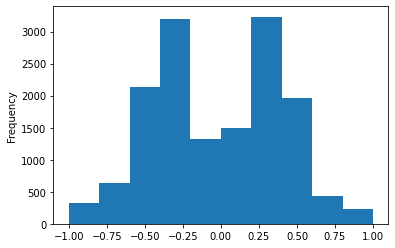

In [ ]:
a['Political'].plot(kind='hist')

## Expansion to tweets and words

In [ ]:
tweets_filtered['political'] = float(0)
htlist = a['Id'].tolist()
for index, row in tweets_filtered.iterrows():
  if row['hashtags']:
    algn = float(0)
    for ht in row['hashtags']:
      if ht in htlist:
        algn += float(a[a['Id']==ht]['Political'])
    tweets_filtered.loc[index,'political'] = algn/len(row['hashtags'])

In [ ]:
unique_political = {}
for idx, row in tweets_filtered.iterrows():
  if row["clean_text"] != "":
    for word in tokenizer.tokenize(row["clean_text"]):
      unique_political.setdefault(word,float(0))
      unique_political[word] += float(row["political"])
word_nodes['Political'] = word_nodes['Id'].apply(lambda word: unique_political[word])/word_nodes['Count']

In [ ]:
tweets_filtered['alignment'] = tweets_filtered['political']*tweets_filtered['sentiment']

In [ ]:
word_nodes['Alignment'] = word_nodes['Political']*word_nodes['Sentiment']

## nodelist output

In [ ]:
nodelist = hashtag_nodes.append(word_nodes, ignore_index=True)

In [ ]:
nodelist.to_csv("nodelist.csv",index=False)
hashtag_nodes.to_csv("hashtaglist.csv",index=False)
word_nodes.to_csv("wordlist.csv",index=False)

In [ ]:
nodelist

,Id,Label,Count,Sentiment,Political,Alignment
0,#democrats,#democrats,11842,-0.212925,-0.995957,0.212064
1,#republicans,#republicans,8210,-0.219785,0.985358,-0.216567
2,#republican,#republican,5623,-0.150426,1.000000,-0.150426
3,#democrat,#democrat,3107,-0.158615,-1.000000,0.158615
4,#trump,#trump,3068,-0.223627,0.294924,-0.065953
...,...,...,...,...,...,...
34712,specialize,specialize,1,-0.357771,-0.995957,0.356324
34713,qari,qari,1,-0.600999,0.582448,-0.350051
34714,prefect,prefect,1,0.779230,-0.225177,-0.175465
34715,641,641,1,0.589067,0.410991,0.242101
